In [1]:
import sys
sys.path.append('../') # or just install the module
sys.path.append('../../fuzzy-tools') # or just install the module

In [2]:
from fuzzytools.files import search_for_filedirs
from lchandler import _C

root_folder = '../../surveys-save'
filedirs = search_for_filedirs(root_folder, fext=_C.EXT_RAW_LIGHTCURVE)

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
from fuzzytools.progress_bars import ProgressBar
from fuzzytools.files import load_pickle, save_pickle
from fuzzytools.files import get_dict_from_filedir

filedir = f'../../surveys-save/survey=alerceZTFv7.1~bands=gr~mode=onlySNe.ralcds'
filedict = get_dict_from_filedir(filedir)
root_folder = filedict['_rootdir']
cfilename = filedict['_cfilename']
survey = filedict['survey']
lcdataset = load_pickle(filedir)
print(lcdataset)

LCDataset:
[outliers; samples 10]
(.) obs_samples=541; min_len=14; max_dur=408.0[days]; dur(p50)=133.8[days]; cadence(p50)=1.0[days]
(g) obs_samples=260; min_len=6; tmax=20.474609375; max_dur=408.0 [days]; dur(p50)=133.8 [days]; cadence(p50)=3.0 [days]
(r) obs_samples=281; min_len=8; tmax=107.873046875; max_dur=376.0 [days]; dur(p50)=128.7 [days]; cadence(p50)=3.0 [days]
   |█▌      | SLSN - 2/10 (20.00%)
   |████    | SNIIbn - 5/10 (50.00%)
   |▊       | SNIa - 1/10 (10.00%)
   |█▌      | SNIbc - 2/10 (20.00%)
────────────────────────────────────────────────────────────────────────────────────────────────────
[faint; samples 0]
empty lcset
────────────────────────────────────────────────────────────────────────────────────────────────────
[raw; samples 1,988]
(.) obs_samples=54,433; min_len=6; max_dur=538.8[days]; dur(p50)=52.9[days]; cadence(p50)=1.0[days]
(g) obs_samples=24,016; min_len=0; tmax=10.99609375; max_dur=538.8 [days]; dur(p50)=38.9 [days]; cadence(p50)=3.0 [days]
(r) obs_

In [4]:
%load_ext autoreload
%autoreload 2

kfolds = 5
new_sets_props = {
    'raw_train':0.6,
    'raw_val':0.2,
    'raw_test':0.2,
    }
lcdataset.split('raw', new_sets_props, kfolds)
print(lcdataset)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
LCDataset:
[outliers; samples 10]
(.) obs_samples=541; min_len=14; max_dur=408.0[days]; dur(p50)=133.8[days]; cadence(p50)=1.0[days]
(g) obs_samples=260; min_len=6; tmax=20.474609375; max_dur=408.0 [days]; dur(p50)=133.8 [days]; cadence(p50)=3.0 [days]
(r) obs_samples=281; min_len=8; tmax=107.873046875; max_dur=376.0 [days]; dur(p50)=128.7 [days]; cadence(p50)=3.0 [days]
   |█▌      | SLSN - 2/10 (20.00%)
   |████    | SNIIbn - 5/10 (50.00%)
   |▊       | SNIa - 1/10 (10.00%)
   |█▌      | SNIbc - 2/10 (20.00%)
────────────────────────────────────────────────────────────────────────────────────────────────────
[faint; samples 0]
empty lcset
────────────────────────────────────────────────────────────────────────────────────────────────────
[raw; samples 1,988]
(.) obs_samples=54,433; min_len=6; max_dur=538.8[days]; dur(p50)=52.9[days]; cadence(p50)=1.0[days]
(g) obs_samples=24,016; min_len=0; tmax=1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


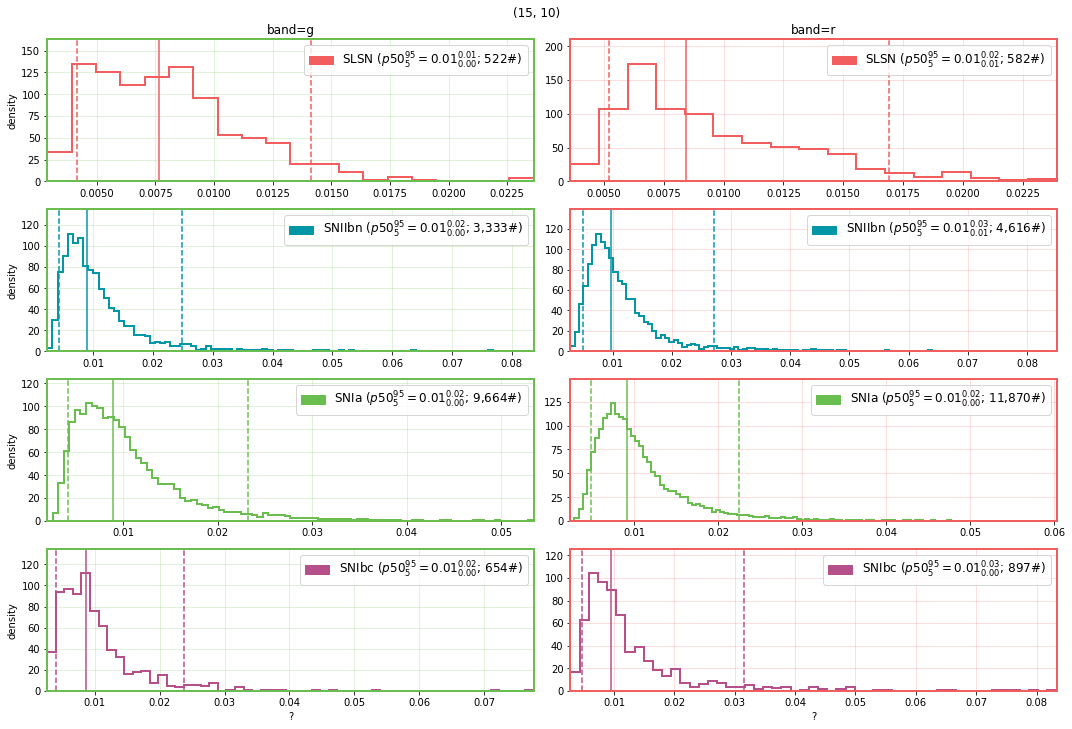

In [5]:
%load_ext autoreload
%autoreload 2
from lchandler.plots.distrs import plot_sigma_distribution

plot_sigma_distribution(lcdataset, '0@raw_train')

In [6]:
%load_ext autoreload
%autoreload 2

for kf in lcdataset.kfolds:
    for ks,set_name in enumerate([f'{kf}@raw_train', f'{kf}@raw_val', f'{kf}@raw_test']):
        lcdataset.sigma_clipping(set_name, set_name.replace('raw_',''),
            sigma_n=1,
            sigma_m=5, # 1, 3, 5
            apply_lower_bound=False,
            verbose=1,
            )

print(lcdataset)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
LCDataset:
[outliers; samples 10]
(.) obs_samples=541; min_len=14; max_dur=408.0[days]; dur(p50)=133.8[days]; cadence(p50)=1.0[days]
(g) obs_samples=260; min_len=6; tmax=20.474609375; max_dur=408.0 [days]; dur(p50)=133.8 [days]; cadence(p50)=3.0 [days]
(r) obs_samples=281; min_len=8; tmax=107.873046875; max_dur=376.0 [days]; dur(p50)=128.7 [days]; cadence(p50)=3.0 [days]
   |█▌      | SLSN - 2/10 (20.00%)
   |████    | SNIIbn - 5/10 (50.00%)
   |▊       | SNIa - 1/10 (10.00%)
   |█▌      | SNIbc - 2/10 (20.00%)
────────────────────────────────────────────────────────────────────────────────────────────────────
[faint; samples 0]
empty lcset
────────────────────────────────────────────────────────────────────────────────────────────────────
[raw; samples 1,988]
(.) obs_samples=54,433; min_len=6; max_dur=538.8[days]; dur(p50)=52.9[days]; cadence(p50)=1.0[days]
(g) obs_samples=24,016; min_len=0; tmax=1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


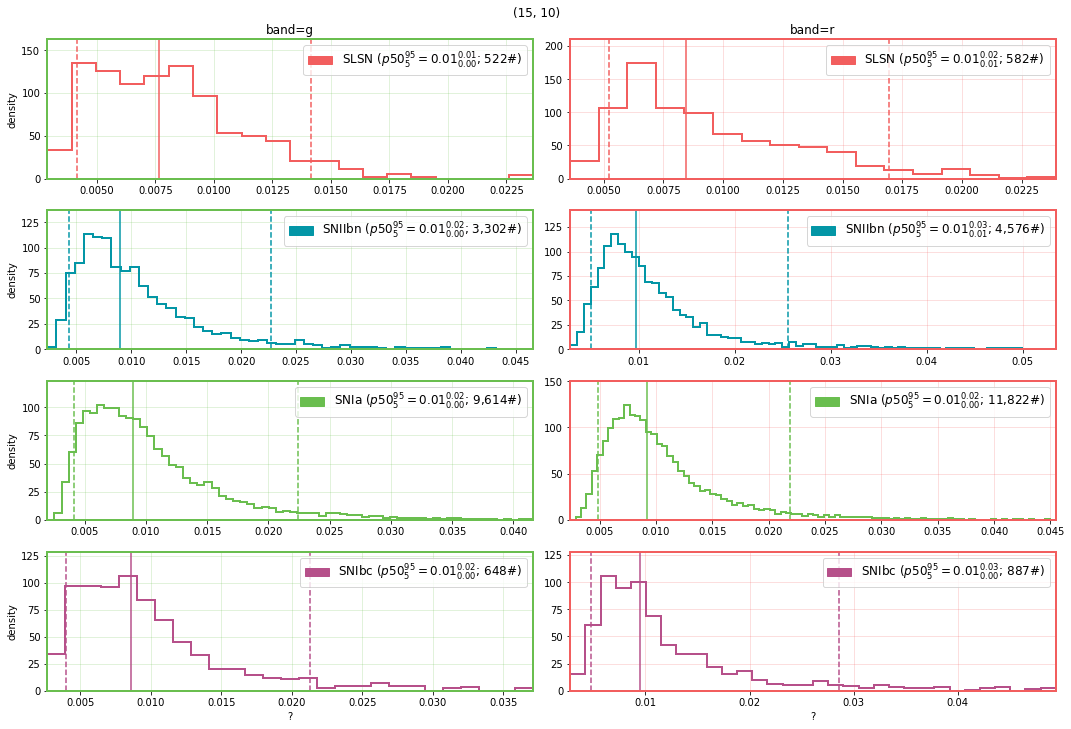

In [7]:
%load_ext autoreload
%autoreload 2
from lchandler.plots.distrs import plot_sigma_distribution

plot_sigma_distribution(lcdataset, '0@train')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


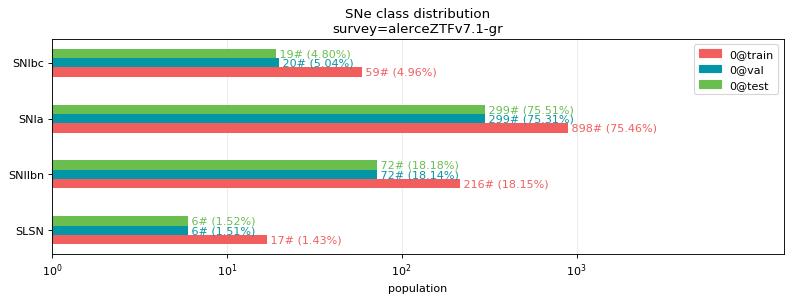

In [8]:
%load_ext autoreload
%autoreload 2
from lchandler.plots.distrs import plot_class_distribution

plot_class_distribution(lcdataset, ['0@train', '0@val', '0@test'])

In [10]:
from fuzzytools.files import load_pickle, save_pickle
from lchandler import _C

new_cfilename = f'{cfilename}'
save_filedir = f'{root_folder}/{new_cfilename}.{_C.EXT_SPLIT_LIGHTCURVE}'
save_pickle(save_filedir, lcdataset)